In [1]:
#import packages
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ini_data = pd.ExcelFile('Сектор роста_качественные данные.xlsx')
qualitat = ini_data.parse('Qualitative_data (2)')

qualitat.drop(['№', 'Year', 'Name'], axis=1, inplace=True)
qualitat = qualitat.rename(columns={"Default": "target"}) #target = дефолт (1 или 0)
qualitat.head()

,target,Comp_age,Corp_group,Courts,Audit_qual,Adress,Ind_innov,Competition,M_founder,Discl_lev,Man_change,Is_Europe,Is_Asia,Is_service,Is_JointStock,Is_SME,Is_LLC
0,0,22.5,1,0,10.0,0,10,1.0,0,1,0,1,0,0,1,0,0
1,0,23.5,1,0,10.0,0,7,1.0,0,1,0,1,0,0,1,0,0
2,0,24.5,1,0,10.0,0,10,1.0,0,1,0,1,0,0,1,0,0
3,0,25.5,1,1,10.0,0,10,1.0,0,1,0,1,0,0,1,0,0
4,0,26.5,1,0,10.0,0,10,1.0,0,1,0,1,0,0,1,0,0


In [2]:
#изначально 17 переменных
qualitat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 17 columns):
target           885 non-null int64
Comp_age         885 non-null float64
Corp_group       885 non-null int64
Courts           885 non-null int64
Audit_qual       885 non-null float64
Adress           885 non-null int64
Ind_innov        885 non-null int64
Competition      885 non-null float64
M_founder        885 non-null int64
Discl_lev        885 non-null int64
Man_change       885 non-null int64
Is_Europe        885 non-null int64
Is_Asia          885 non-null int64
Is_service       885 non-null int64
Is_JointStock    885 non-null int64
Is_SME           885 non-null int64
Is_LLC           885 non-null int64
dtypes: float64(3), int64(14)
memory usage: 117.6 KB


In [3]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [4]:
final_iv, IV = data_vars(qualitat,qualitat.target)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


In [5]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Comp_age,3.0,14.0,464,169,0.364224,295,0.635776,0.603571,0.487603,0.213362,0.054501
1,Comp_age,14.5,30.0,421,111,0.263658,310,0.736342,0.396429,0.512397,-0.256603,0.054501
2,Corp_group,0.0,0.0,295,115,0.389831,180,0.610169,0.410714,0.297521,0.322414,0.056384
3,Corp_group,1.0,1.0,590,165,0.279661,425,0.720339,0.589286,0.702479,-0.175705,0.056384
4,Courts,0.0,0.0,499,124,0.248497,375,0.751503,0.442857,0.619835,-0.336206,0.127144
5,Courts,1.0,1.0,386,156,0.404145,230,0.595855,0.557143,0.380165,0.382216,0.127144
6,Audit_qual,1.0,1.0,22,0,0.000000,22,1.000000,0.000000,0.036364,0.000000,0.001347
7,Audit_qual,1.9,10.0,863,280,0.324450,583,0.675550,1.000000,0.963636,0.037041,0.001347
8,Adress,0.0,0.0,850,270,0.317647,580,0.682353,0.964286,0.958678,0.005833,0.000851
9,Adress,1.0,1.0,35,10,0.285714,25,0.714286,0.035714,0.041322,-0.145852,0.000851


In [6]:
IV.sort_values('IV')

,VAR_NAME,IV
0,Adress,0.000851
7,Ind_innov,0.001164
1,Audit_qual,0.001347
8,Is_Asia,0.003008
6,Discl_lev,0.003418
10,Is_JointStock,0.015378
13,Is_service,0.035269
3,Competition,0.046504
14,M_founder,0.048675
15,Man_change,0.051065


In [7]:
#удаляем только те переменные, IV по которым нельзя округлить до 0,1
qualitat = qualitat.drop(['Adress', 'Ind_innov', 'Audit_qual', 'Discl_lev', 'Is_Asia', 'Is_JointStock', 'Is_service'], axis = 1)
qualitat.head()

,target,Comp_age,Corp_group,Courts,Competition,M_founder,Man_change,Is_Europe,Is_SME,Is_LLC
0,0,22.5,1,0,1.0,0,0,1,0,0
1,0,23.5,1,0,1.0,0,0,1,0,0
2,0,24.5,1,0,1.0,0,0,1,0,0
3,0,25.5,1,1,1.0,0,0,1,0,0
4,0,26.5,1,0,1.0,0,0,1,0,0


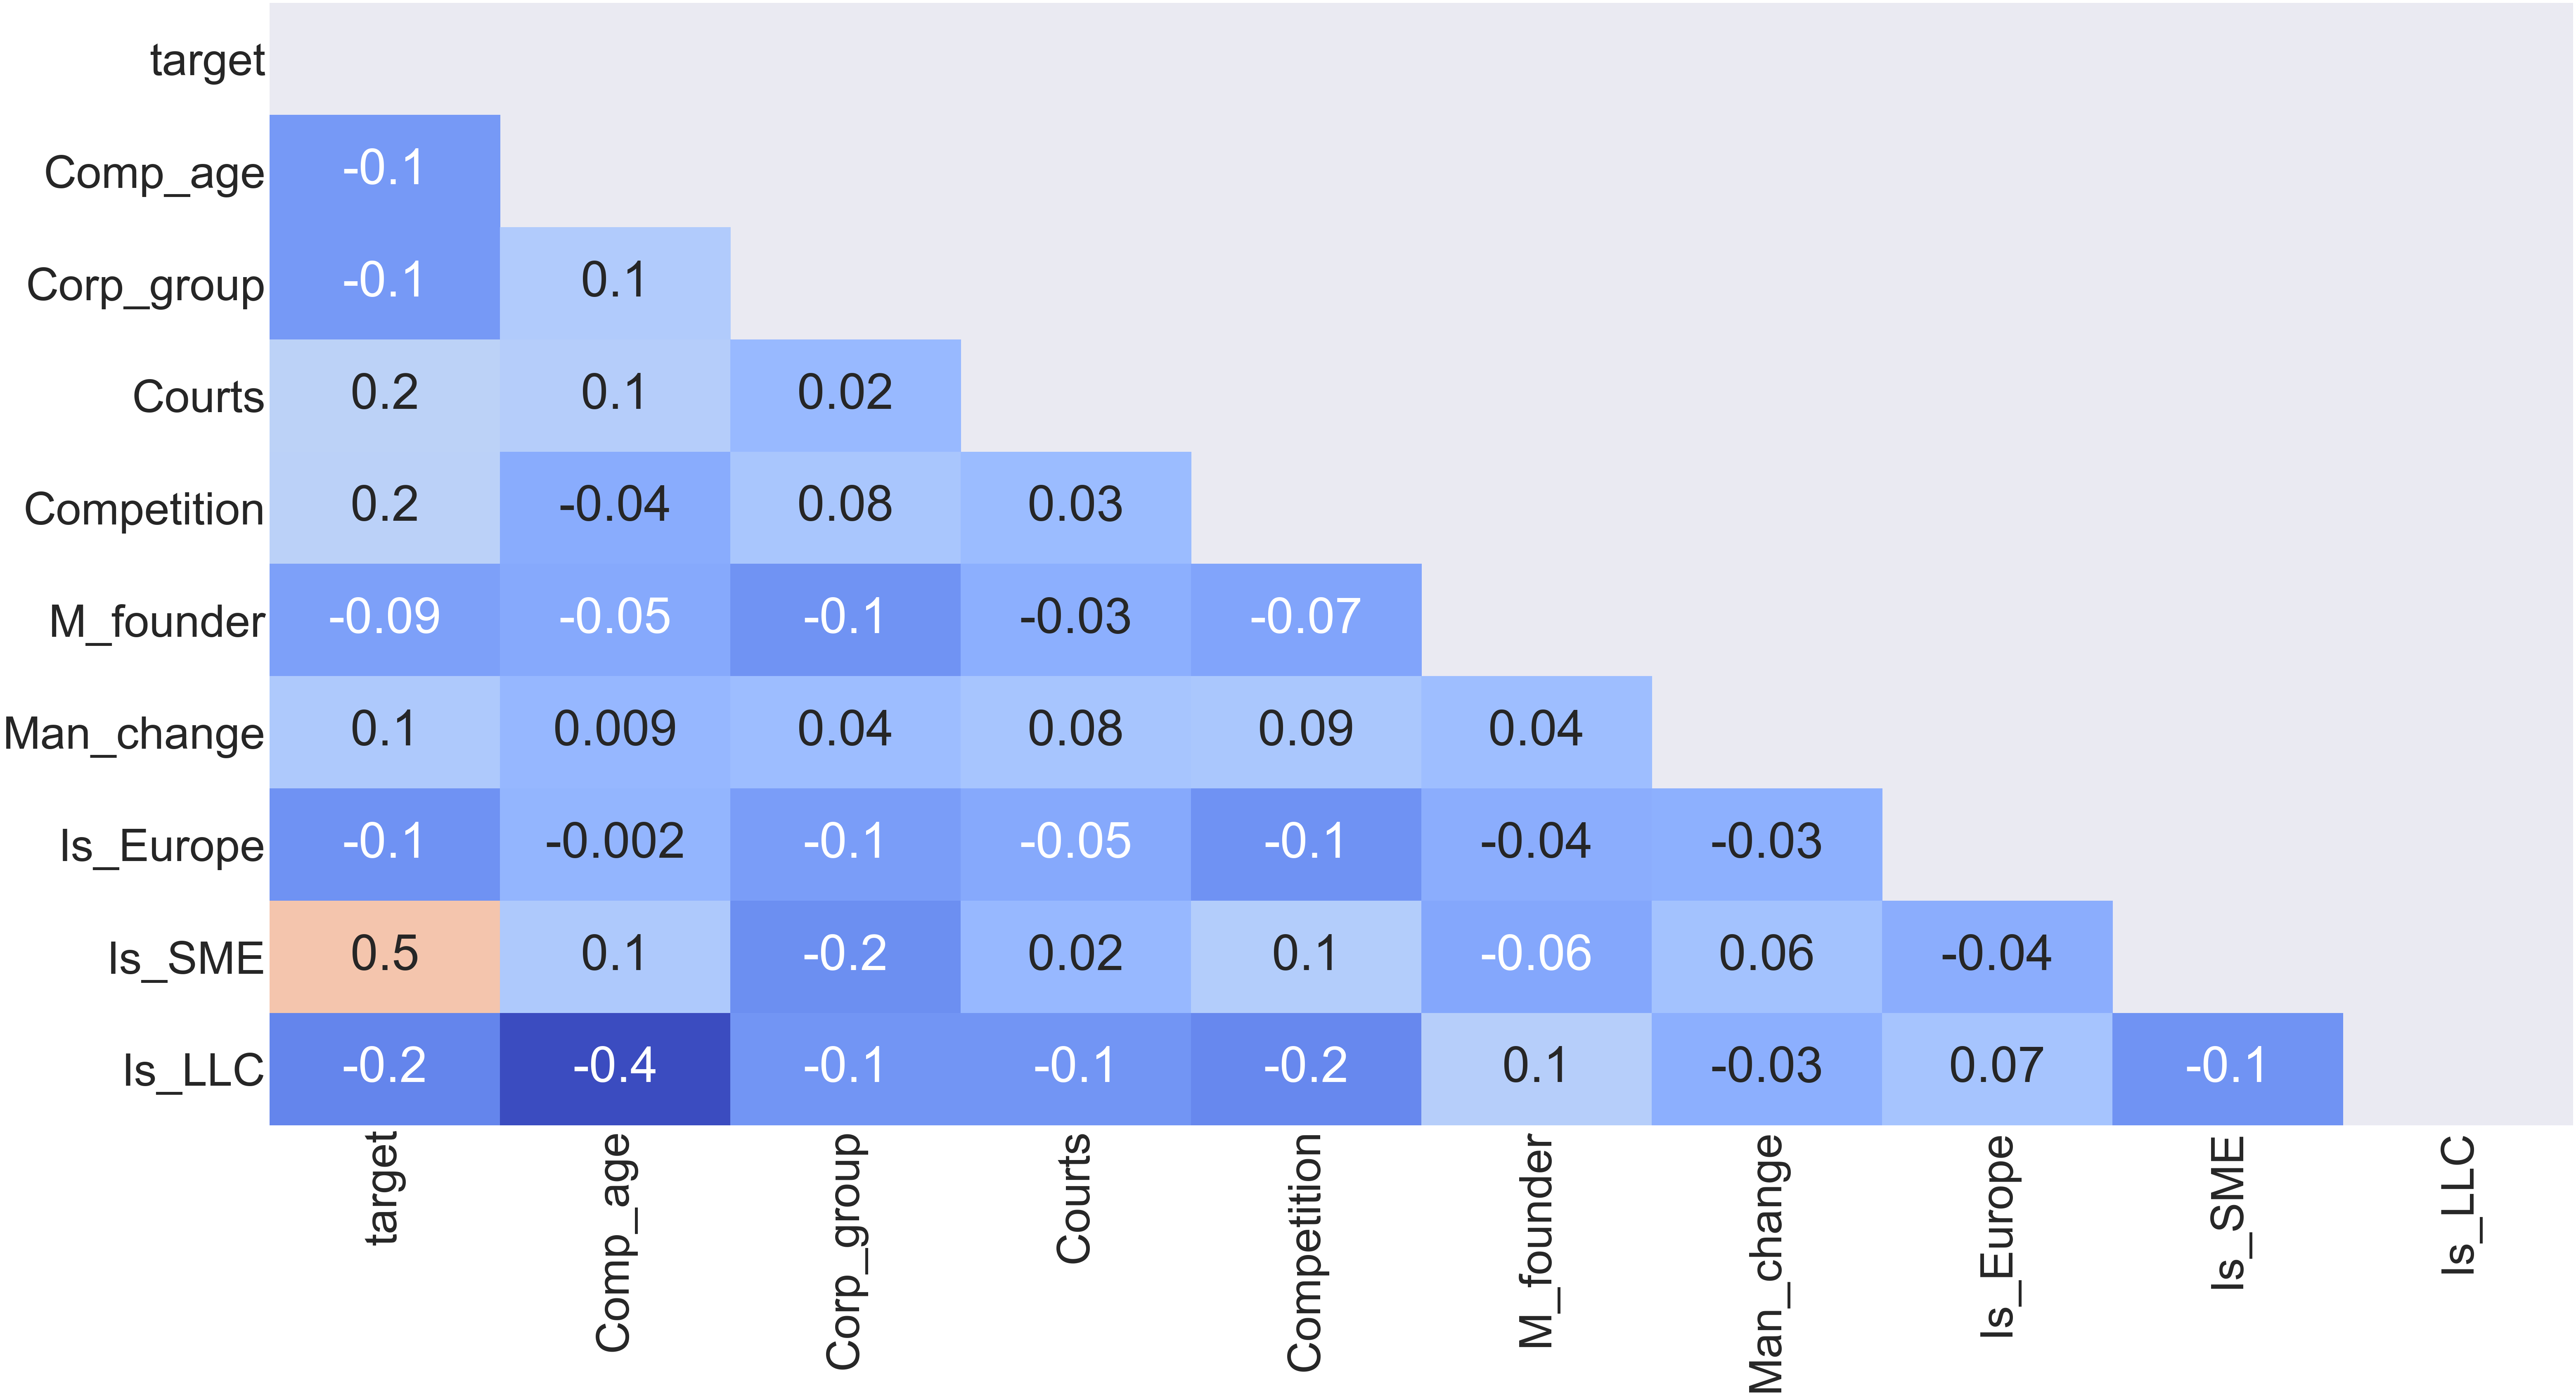

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=10)
f, ax = plt.subplots(figsize=(100, 50))
matrix = np.triu(qualitat.corr(method='pearson'))
sns.heatmap(qualitat.corr(method='pearson'), annot=True, mask=matrix, cbar = False, fmt = '.1g', cmap= 'coolwarm')

In [10]:
ini_data = pd.ExcelFile('Model_data.xlsx')
data = ini_data.parse('Specif2 (2)')
data.head()

,Eq_TL,Eq_TA,Cash_TA,Quick_rat,ROE,EBIT_IntEx,S_TA,CFO_S,CFO_OperPr,CFO_Eq,lnTA,Comp_age,Corp_group,Courts,Competition,M_founder,Man_change,Unempl_rat,Inf_FedReg,Is_Europe,Is_LLC,Is_SME
0,10.000000,8.465741,4.172557,3.814175,4.085654,5.692909,4.467312,0.646345,6.584224,4.131806,6.441322,22.5,1,0,1.0,0,0,1.8,13.70,1,0,0
1,0.000000,8.273048,6.094101,4.541748,4.370627,0.000000,4.272631,5.716218,5.473580,5.278793,6.566862,23.5,1,0,1.0,0,0,1.8,5.90,1,0,0
2,0.000000,6.812008,4.379950,3.714789,2.874080,0.000000,3.777847,3.786230,3.647116,4.846736,6.871392,24.5,1,0,1.0,0,0,1.4,3.18,1,0,0
3,10.000000,6.803930,3.548091,3.520506,4.852327,10.000000,3.817546,3.787249,5.326694,4.842472,7.298961,25.5,1,1,1.0,0,0,1.2,4.70,1,0,0
4,4.975702,4.385216,3.638857,3.521930,3.262918,3.565572,3.180172,2.273206,0.000000,3.832052,0.000000,26.5,1,0,1.0,0,0,1.6,3.00,1,0,0


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
vif = pd.DataFrame() 
vif["feature"] = data.columns 
vif["VIF"] = [variance_inflation_factor(data.values, i) 
                          for i in range(len(data.columns))] 
print(vif)

        feature        VIF
0         Eq_TL   3.334654
1         Eq_TA   9.336227
2       Cash_TA  10.765517
3     Quick_rat  12.796126
4           ROE   5.738760
5    EBIT_IntEx   3.202979
6          S_TA   6.540251
7         CFO_S   9.187281
8    CFO_OperPr   7.610865
9        CFO_Eq   9.470545
10         lnTA   5.930726
11     Comp_age   7.053625
12   Corp_group   3.368554
13       Courts   2.084601
14  Competition   2.565583
15    M_founder   1.118272
16   Man_change   1.041385
17   Unempl_rat   5.378552
18   Inf_FedReg   3.624721
19    Is_Europe   3.834976
20       Is_LLC   4.005264
21       Is_SME   2.834528


In [13]:
test_1 = ini_data.parse('Specif2')
test_1.drop(['lnTA', 'Quick_rat', 'Cash_TA', 'CFO_Eq', 'CFO_S', 'Is_LLC'], axis=1, inplace=True)

vif = pd.DataFrame() 
vif["feature"] = test_1.columns 
vif["VIF"] = [variance_inflation_factor(test_1.values, i) 
                          for i in range(len(test_1.columns))] 

print(vif)

          feature       VIF
0           Eq_TL  3.151189
1           Eq_TA  5.978648
2             ROE  5.169636
3      EBIT_IntEx  3.226971
4            S_TA  5.583993
5      CFO_OperPr  5.288599
6        Comp_age  7.420090
7      Corp_group  3.154933
8          Courts  2.071296
9     Competition  3.007130
10      M_founder  1.083693
11     Man_change  1.040337
12     Unempl_rat  5.857341
13     Inf_FedReg  3.611405
14      Is_Europe  4.857310
15        Is_Asia  1.826927
16     Is_service  3.069881
17  Is_JointStock  1.527980
18         Is_SME  2.573536
